# ECON 5140: Applied Econometrics
## Lesson 6: Dynamic Regression and Causal Interpretation in Time Series

This notebook demonstrates dynamic regression models (ARIMAX) and causal interpretation in time series using simulated tech company data.

**Topics covered:**
1. The problem with OLS in time series (serial correlation)
2. ARIMAX models (regression with ARIMA errors)
3. Conditional vs unconditional forecasts
4. Distributed lag models
5. HAC (Heteroskedasticity and Autocorrelation Consistent) standard errors
6. Long-run effects and cumulative multipliers
7. Forecasting vs causal interpretation

## Use Case: E-commerce Sales Forecasting

**Scenario:** We work for a tech company (similar to Amazon) and want to:
- Forecast daily sales revenue
- Understand how advertising spend affects sales
- Analyze the impact of price changes
- Plan marketing campaigns with scenario analysis

**Key Questions:**
- How much will sales increase if we increase ad spend by 20%?
- What is the long-run effect of a permanent price reduction?
- How do we forecast sales conditional on planned marketing campaigns?

In [1]:
# Import necessary libraries

# Standard library
import warnings
from datetime import datetime, timedelta

# Third-party libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Statsmodels for ARIMAX and HAC
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.regression.linear_model import OLS
from statsmodels.stats.sandwich_covariance import cov_hac
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller, acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Suppress warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Set random seed for reproducibility
np.random.seed(42)

## Part 1: Generate Simulated Tech Company Data

We'll simulate realistic e-commerce data with:
- **Sales revenue**: Daily sales in millions of dollars
- **Advertising spend**: Daily marketing/advertising expenditure
- **Price index**: Relative price level (1.0 = baseline)
- **Seasonality**: Weekly and monthly patterns
- **Trends**: Long-term growth
- **Serial correlation**: Realistic time series dynamics

In [2]:
# Generate simulated data
print("Generating simulated e-commerce data...")
print("=" * 60)

# Create date range: 3 years of daily data
n_days = 3 * 365
start_date = pd.Timestamp('2021-01-01')
dates = pd.date_range(start=start_date, periods=n_days, freq='D')

T = len(dates)

# 1. Generate advertising spend (exogenous, policy-controlled)
# Base level with some variation
ad_base = 2.0  # Base ad spend in millions
ad_trend = np.linspace(0, 0.5, T)  # Gradual increase
ad_seasonal = 0.3 * np.sin(2 * np.pi * np.arange(T) / 365.25)  # Annual seasonality
ad_noise = np.random.normal(0, 0.2, T)
ad_spend = ad_base + ad_trend + ad_seasonal + ad_noise
ad_spend = np.maximum(ad_spend, 0.5)  # Floor at 0.5M

# 2. Generate price index (exogenous, policy-controlled)
# Prices change occasionally (promotions, policy changes)
price_base = 1.0
price_changes = np.random.choice([-0.1, 0, 0.1], size=T, p=[0.05, 0.9, 0.05])
price_index = price_base + np.cumsum(price_changes)
price_index = np.maximum(price_index, 0.7)  # Floor at 0.7
price_index = np.minimum(price_index, 1.3)  # Ceiling at 1.3

# 3. Generate sales revenue (endogenous, depends on ads, price, and dynamics)
# True model: sales_t = 10 + 1.5*ad_t + -3*price_t + distributed_lags + ARIMA errors

# Immediate effect of advertising (contemporary)
ad_effect_contemporary = 1.5 * ad_spend

# Distributed lag effect of advertising (persistent impact)
# Ads have effects that last several days
ad_effect_lag1 = 0.8 * np.roll(ad_spend, 1)
ad_effect_lag1[0] = 0
ad_effect_lag2 = 0.5 * np.roll(ad_spend, 2)
ad_effect_lag2[:2] = 0
ad_effect_lag3 = 0.3 * np.roll(ad_spend, 3)
ad_effect_lag3[:3] = 0

# Total ad effect (distributed lag)
ad_effect_total = ad_effect_contemporary + ad_effect_lag1 + ad_effect_lag2 + ad_effect_lag3

# Price effect (negative: lower price -> higher sales)
price_effect = -3.0 * price_index

# Base level and trend
sales_base = 10.0
sales_trend = 0.01 * np.arange(T) / 365  # Slow growth

# Weekly seasonality (weekends have higher sales)
day_of_week = dates.dayofweek
weekly_seasonal = 1.5 * (day_of_week >= 5).astype(float)  # Weekend boost

# Monthly seasonality (holiday effects)
month = dates.month
monthly_seasonal = 2.0 * ((month == 11) | (month == 12)).astype(float)  # Nov/Dec boost

# Generate ARIMA(1,0,1) errors for serial correlation
errors = np.zeros(T)
for t in range(1, T):
    errors[t] = 0.6 * errors[t-1] + np.random.normal(0, 1.5) + 0.3 * np.random.normal(0, 1.5)

# Combine all effects
sales_revenue = (sales_base + sales_trend + 
                 ad_effect_total + 
                 price_effect + 
                 weekly_seasonal + 
                 monthly_seasonal + 
                 errors)

# Ensure non-negative
sales_revenue = np.maximum(sales_revenue, 1.0)

# Create DataFrame
df = pd.DataFrame({
    'date': dates,
    'sales': sales_revenue,
    'ad_spend': ad_spend,
    'price_index': price_index,
    'day_of_week': day_of_week,
    'month': month,
    'is_weekend': (day_of_week >= 5).astype(int)
}, index=dates)

print(f"✓ Generated {len(df)} days of simulated data")
print(f"  Date range: {df['date'].min()} to {df['date'].max()}")
print(f"  Sales range: ${df['sales'].min():.2f}M to ${df['sales'].max():.2f}M")
print(f"  Ad spend range: ${df['ad_spend'].min():.2f}M to ${df['ad_spend'].max():.2f}M")
print(f"  Price index range: {df['price_index'].min():.2f} to {df['price_index'].max():.2f}")

# Display first few rows
print("\n" + "=" * 60)
print("First 10 rows:")
print(df.head(10).to_string())

Generating simulated e-commerce data...
✓ Generated 1095 days of simulated data
  Date range: 2021-01-01 00:00:00 to 2023-12-31 00:00:00
  Sales range: $7.69M to $21.10M
  Ad spend range: $1.18M to $3.15M
  Price index range: 0.80 to 1.30

First 10 rows:
                 date      sales  ad_spend  price_index  day_of_week  month  is_weekend
2021-01-01 2021-01-01  10.149014  2.099343          1.0            4      1           0
2021-01-02 2021-01-02  13.906052  1.977965          1.0            5      1           1
2021-01-03 2021-01-03  15.165278  2.140771          0.9            6      1           1
2021-01-04 2021-01-04  15.894128  2.321452          0.9            0      1           0
2021-01-05 2021-01-05  13.947570  1.975624          1.0            1      1           0
2021-01-06 2021-01-06  12.133498  1.981230          1.1            2      1           0
2021-01-07 2021-01-07  11.973508  2.349494          1.0            3      1           0
2021-01-08 2021-01-08  13.876792  2.19272

## Part 2: Exploratory Data Analysis

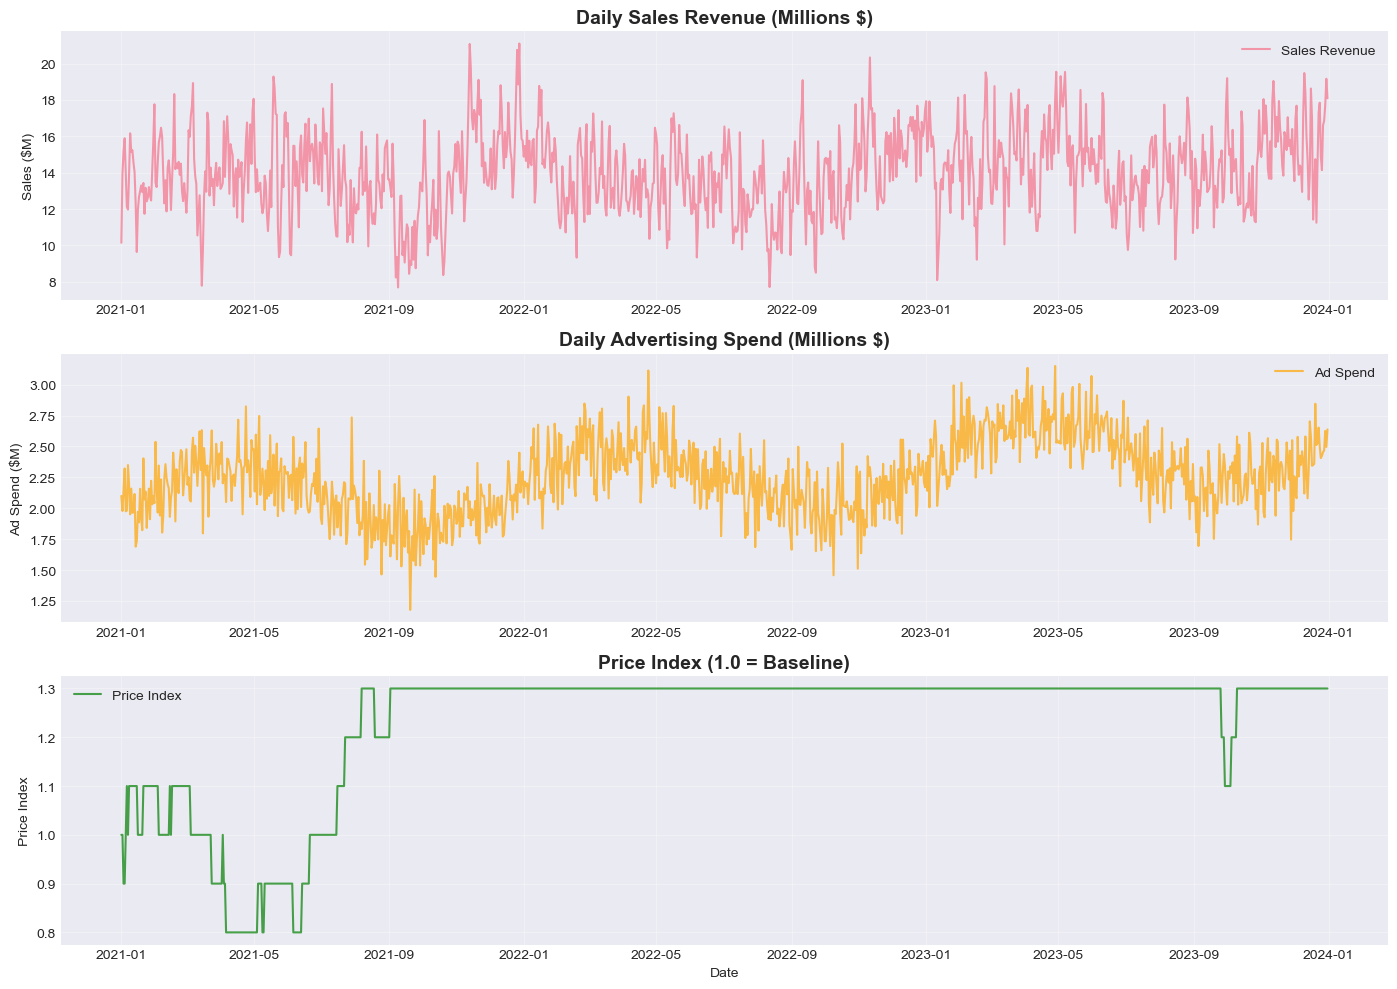

In [3]:
# Plot time series
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Sales
axes[0].plot(df.index, df['sales'], linewidth=1.5, alpha=0.7, label='Sales Revenue')
axes[0].set_title('Daily Sales Revenue (Millions $)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Sales ($M)')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Advertising spend
axes[1].plot(df.index, df['ad_spend'], linewidth=1.5, alpha=0.7, color='orange', label='Ad Spend')
axes[1].set_title('Daily Advertising Spend (Millions $)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Ad Spend ($M)')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

# Price index
axes[2].plot(df.index, df['price_index'], linewidth=1.5, alpha=0.7, color='green', label='Price Index')
axes[2].set_title('Price Index (1.0 = Baseline)', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Price Index')
axes[2].set_xlabel('Date')
axes[2].grid(True, alpha=0.3)
axes[2].legend()

plt.tight_layout()
plt.show()

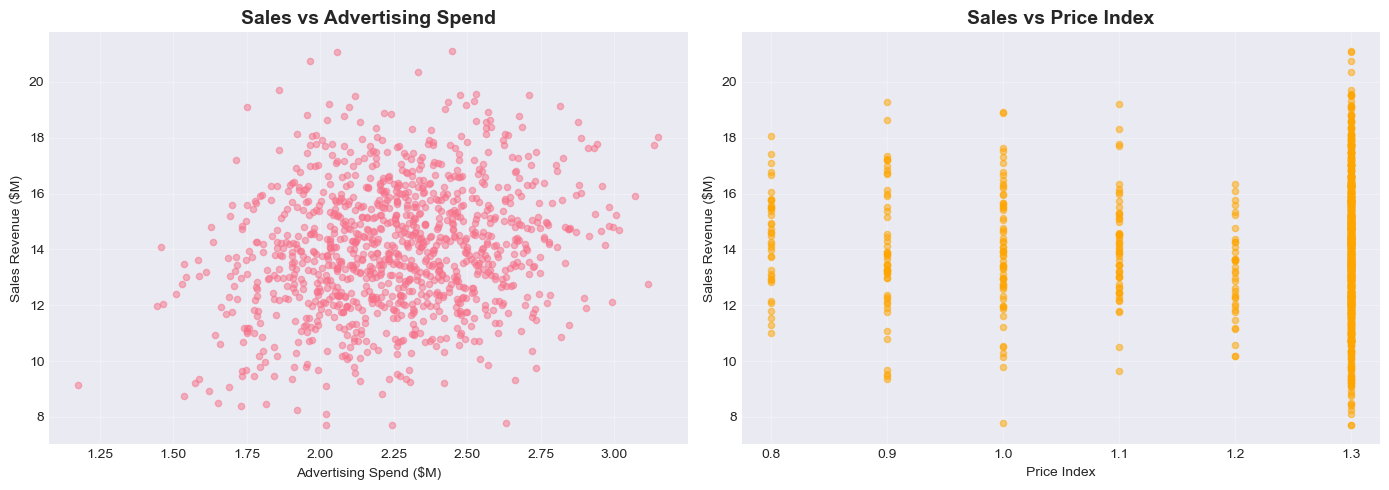

In [4]:
# Scatter plots: Sales vs predictors
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Sales vs Ad Spend
axes[0].scatter(df['ad_spend'], df['sales'], alpha=0.5, s=20)
axes[0].set_xlabel('Advertising Spend ($M)')
axes[0].set_ylabel('Sales Revenue ($M)')
axes[0].set_title('Sales vs Advertising Spend', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Sales vs Price Index
axes[1].scatter(df['price_index'], df['sales'], alpha=0.5, s=20, color='orange')
axes[1].set_xlabel('Price Index')
axes[1].set_ylabel('Sales Revenue ($M)')
axes[1].set_title('Sales vs Price Index', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Part 3: The Problem with OLS in Time Series

Let's start with a naive OLS regression and see why it fails when errors are serially correlated.

In [5]:
# Split data into train and test
train_size = int(0.8 * len(df))
train = df.iloc[:train_size].copy()
test = df.iloc[train_size:].copy()

print(f"Training set: {len(train)} observations ({train.index[0]} to {train.index[-1]})")
print(f"Test set: {len(test)} observations ({test.index[0]} to {test.index[-1]})")
print("=" * 60)

Training set: 876 observations (2021-01-01 00:00:00 to 2023-05-26 00:00:00)
Test set: 219 observations (2023-05-27 00:00:00 to 2023-12-31 00:00:00)


Fitting OLS regression...

OLS Results:
                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     26.59
Date:                Sun, 08 Feb 2026   Prob (F-statistic):           6.18e-12
Time:                        09:35:33   Log-Likelihood:                -1940.6
No. Observations:                 876   AIC:                             3887.
Df Residuals:                     873   BIC:                             3901.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const     

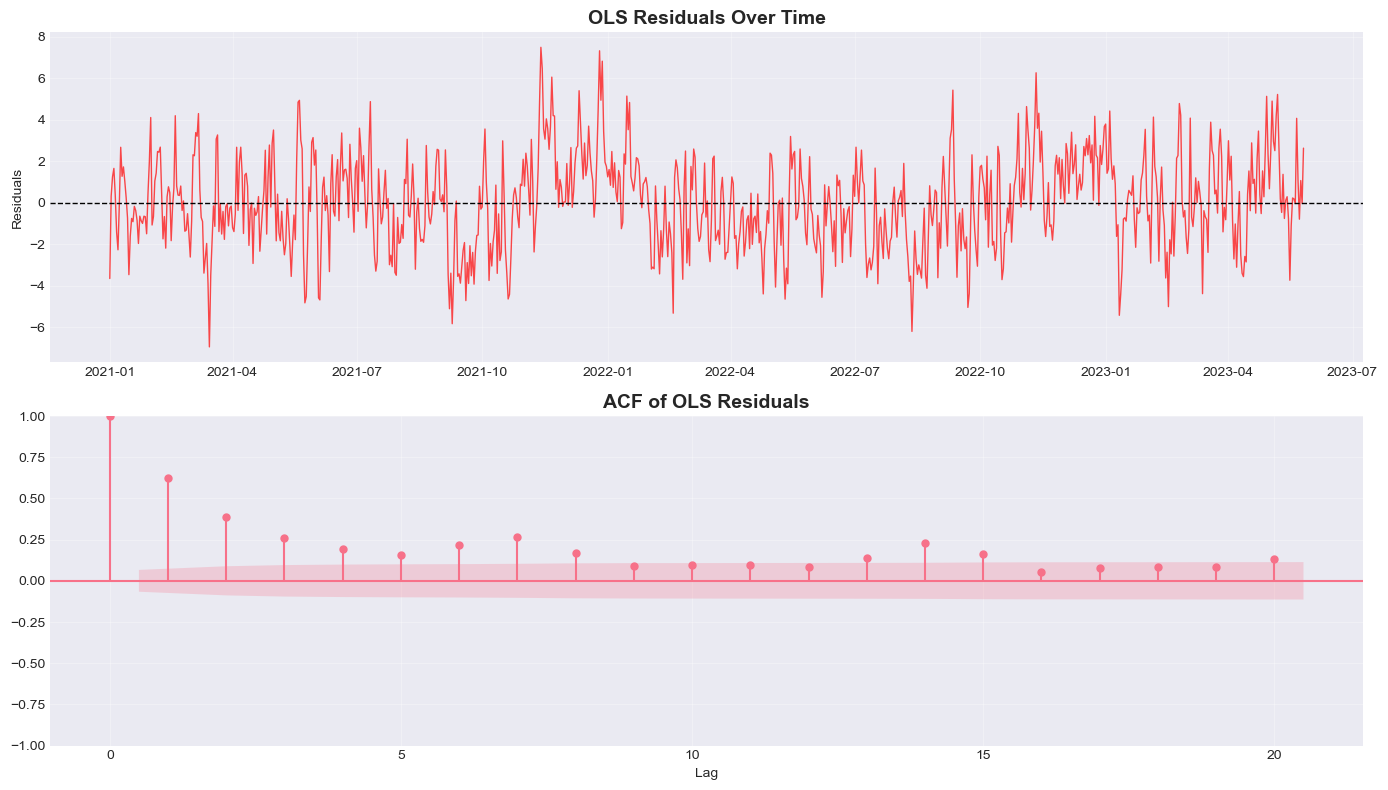


Key Takeaway: OLS assumes independent errors, but we have serial correlation!
This means standard errors are wrong, and forecasts are inefficient.


In [6]:
# Naive OLS regression
print("Fitting OLS regression...")
print("=" * 60)

# Prepare data
X_train = sm.add_constant(train[['ad_spend', 'price_index']])
y_train = train['sales']

# Fit OLS
ols_model = OLS(y_train, X_train).fit()

print("\nOLS Results:")
print(ols_model.summary())

# Check for serial correlation in residuals
residuals = ols_model.resid

print("\n" + "=" * 60)
print("Serial Correlation Diagnostics:")
print("=" * 60)

# Durbin-Watson test
dw_stat = durbin_watson(residuals)
print(f"\nDurbin-Watson statistic: {dw_stat:.4f}")
print(f"  (DW < 2 suggests positive autocorrelation)")
if dw_stat < 1.5:
    print("  ⚠ Strong evidence of positive serial correlation!")
elif dw_stat < 2.0:
    print("  ⚠ Evidence of positive serial correlation")
else:
    print("  ✓ No strong evidence of serial correlation")

# Ljung-Box test
ljung_box = acorr_ljungbox(residuals, lags=10, return_df=True)
print(f"\nLjung-Box test (H0: No serial correlation):")
print(f"  p-value (lag 10): {ljung_box['lb_pvalue'].iloc[-1]:.4f}")
if ljung_box['lb_pvalue'].iloc[-1] < 0.05:
    print("  ⚠ Reject H0: Strong evidence of serial correlation!")
else:
    print("  ✓ Fail to reject H0: No strong evidence of serial correlation")

# Plot residuals
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Residuals over time
axes[0].plot(train.index, residuals, linewidth=1, alpha=0.7, color='red')
axes[0].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[0].set_title('OLS Residuals Over Time', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Residuals')
axes[0].grid(True, alpha=0.3)

# ACF of residuals
plot_acf(residuals, lags=20, ax=axes[1], alpha=0.05)
axes[1].set_title('ACF of OLS Residuals', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Lag')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("Key Takeaway: OLS assumes independent errors, but we have serial correlation!")
print("This means standard errors are wrong, and forecasts are inefficient.")

## Part 4: ARIMAX Model (Regression with ARIMA Errors)

ARIMAX models the regression relationship while explicitly accounting for serial correlation in errors.

Fitting ARIMAX model (Regression with ARIMA errors)...

ARIMAX Results:
                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                  876
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1717.280
Date:                Sun, 08 Feb 2026   AIC                           3446.561
Time:                        09:35:33   BIC                           3475.213
Sample:                    01-01-2021   HQIC                          3457.520
                         - 05-26-2023                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          12.1302      1.307      9.284      0.000       9.569      14.691
ad_spend        1.1147      0.238      4.692      0.000 

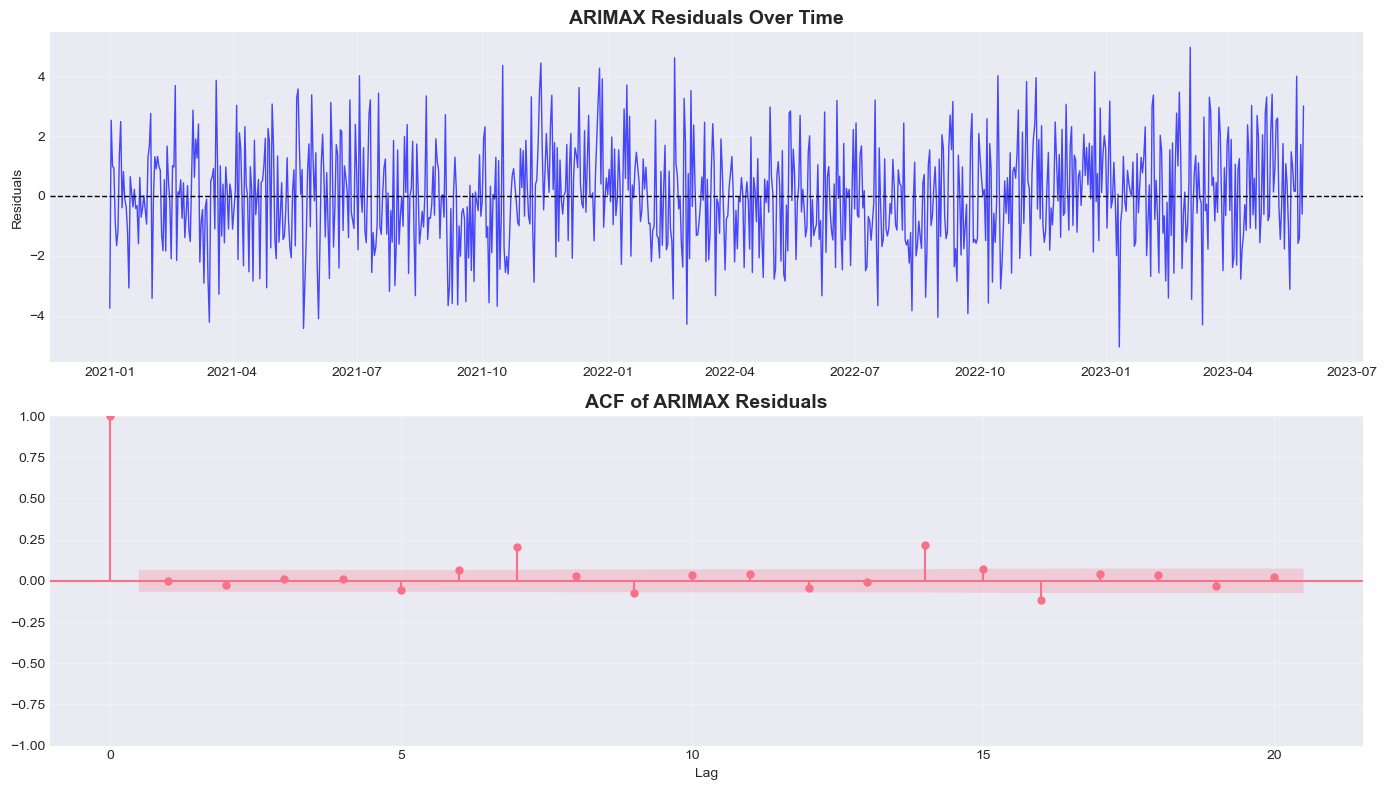

In [7]:
# Fit ARIMAX model
print("Fitting ARIMAX model (Regression with ARIMA errors)...")
print("=" * 60)

# ARIMAX: y_t = beta' * x_t + eta_t, where eta_t ~ ARIMA(p,d,q)
# We'll use ARIMA(1,0,1) for the error process (matching our DGP)

# Prepare exogenous variables
exog_train = train[['ad_spend', 'price_index']]

# Fit ARIMAX(1,0,1) with exogenous regressors
arimax_model = ARIMA(
    endog=train['sales'],
    exog=exog_train,
    order=(1, 0, 1)  # AR(1), I(0), MA(1)
)

arimax_fitted = arimax_model.fit()

print("\nARIMAX Results:")
print(arimax_fitted.summary())

# Check residuals
arimax_residuals = arimax_fitted.resid

print("\n" + "=" * 60)
print("ARIMAX Residual Diagnostics:")
print("=" * 60)

# Ljung-Box test on ARIMAX residuals
ljung_box_arimax = acorr_ljungbox(arimax_residuals, lags=10, return_df=True)
print(f"\nLjung-Box test (H0: No serial correlation):")
print(f"  p-value (lag 10): {ljung_box_arimax['lb_pvalue'].iloc[-1]:.4f}")
if ljung_box_arimax['lb_pvalue'].iloc[-1] < 0.05:
    print("  ⚠ Still some serial correlation (may need higher order ARIMA)")
else:
    print("  ✓ Residuals appear white noise - model captures serial correlation!")

# Plot ARIMAX residuals
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Residuals over time
axes[0].plot(train.index, arimax_residuals, linewidth=1, alpha=0.7, color='blue')
axes[0].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[0].set_title('ARIMAX Residuals Over Time', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Residuals')
axes[0].grid(True, alpha=0.3)

# ACF of residuals
plot_acf(arimax_residuals, lags=20, ax=axes[1], alpha=0.05)
axes[1].set_title('ACF of ARIMAX Residuals', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Lag')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Generating conditional forecasts...

Conditional Forecast (using actual future x):
  MAE: $1.68M
  RMSE: $2.09M

Unconditional Forecast (using last observed x):
  MAE: $1.68M
  RMSE: $2.07M


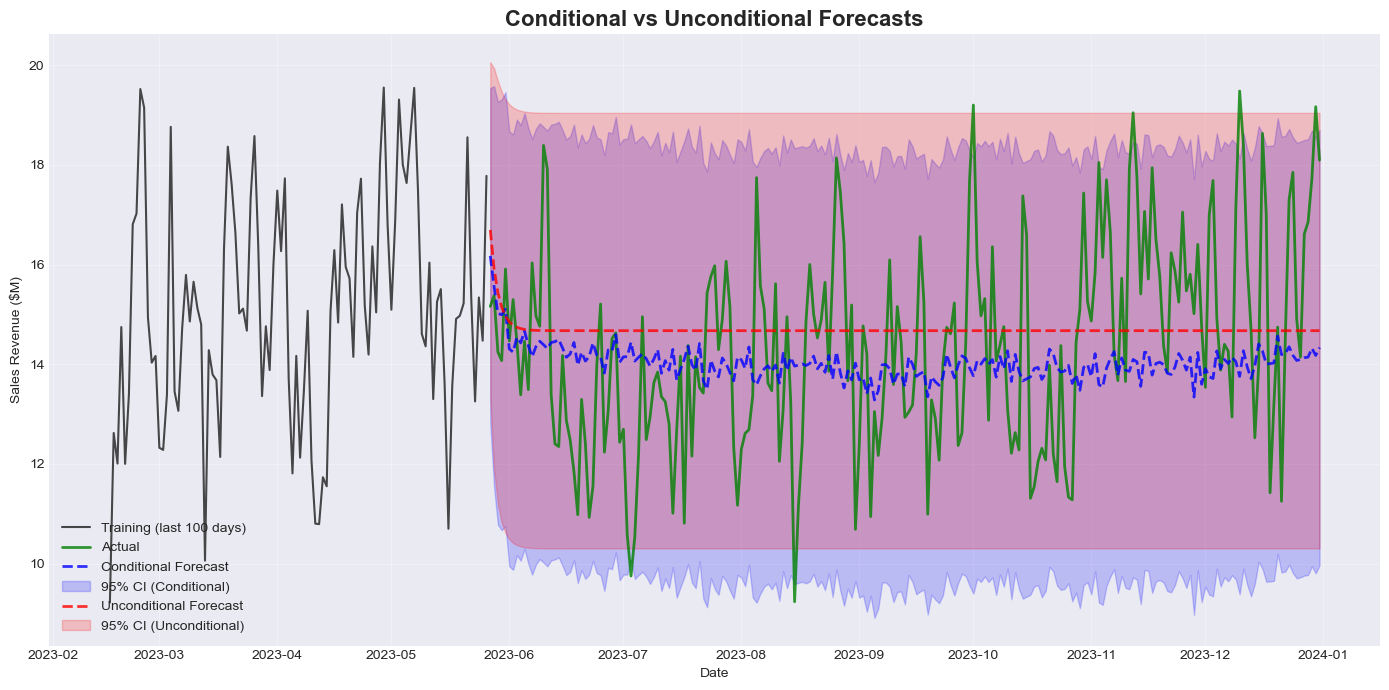


Key Insight: Conditional forecasts are more accurate when we know future x!
This is why scenario analysis is powerful for business planning.


In [8]:
# Conditional forecast: We know future ad_spend and price_index
print("Generating conditional forecasts...")
print("=" * 60)

# Prepare exogenous variables for test period
exog_test = test[['ad_spend', 'price_index']]

# Generate conditional forecast
forecast_result = arimax_fitted.get_forecast(steps=len(test), exog=exog_test)
conditional_forecast = forecast_result.predicted_mean
conditional_ci = forecast_result.conf_int()

# Unconditional forecast: We don't know future x, so we use last values
# (In practice, you'd forecast x first, but for simplicity we use last observed values)
last_ad = train['ad_spend'].iloc[-1]
last_price = train['price_index'].iloc[-1]
exog_unconditional = pd.DataFrame({
    'ad_spend': [last_ad] * len(test),
    'price_index': [last_price] * len(test)
}, index=test.index)

forecast_unconditional = arimax_fitted.get_forecast(steps=len(test), exog=exog_unconditional)
unconditional_forecast = forecast_unconditional.predicted_mean
unconditional_ci = forecast_unconditional.conf_int()

# Compare forecasts
print(f"\nConditional Forecast (using actual future x):")
print(f"  MAE: ${mean_absolute_error(test['sales'], conditional_forecast):.2f}M")
print(f"  RMSE: ${np.sqrt(mean_squared_error(test['sales'], conditional_forecast)):.2f}M")

print(f"\nUnconditional Forecast (using last observed x):")
print(f"  MAE: ${mean_absolute_error(test['sales'], unconditional_forecast):.2f}M")
print(f"  RMSE: ${np.sqrt(mean_squared_error(test['sales'], unconditional_forecast)):.2f}M")

# Plot forecasts
fig, ax = plt.subplots(figsize=(14, 7))

# Plot last 100 days of training data for context
train_tail = train.tail(100)
ax.plot(train_tail.index, train_tail['sales'], 'k-', linewidth=1.5, alpha=0.7, label='Training (last 100 days)')

# Plot actual test data
ax.plot(test.index, test['sales'], 'g-', linewidth=2, alpha=0.8, label='Actual')

# Plot conditional forecast
ax.plot(test.index, conditional_forecast, 'b--', linewidth=2, alpha=0.8, label='Conditional Forecast')
ax.fill_between(test.index, conditional_ci.iloc[:, 0], conditional_ci.iloc[:, 1], 
                alpha=0.2, color='blue', label='95% CI (Conditional)')

# Plot unconditional forecast
ax.plot(test.index, unconditional_forecast, 'r--', linewidth=2, alpha=0.8, label='Unconditional Forecast')
ax.fill_between(test.index, unconditional_ci.iloc[:, 0], unconditional_ci.iloc[:, 1], 
                alpha=0.2, color='red', label='95% CI (Unconditional)')

ax.set_title('Conditional vs Unconditional Forecasts', fontsize=16, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Sales Revenue ($M)')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("Key Insight: Conditional forecasts are more accurate when we know future x!")
print("This is why scenario analysis is powerful for business planning.")

## Part 6: Scenario Analysis

**Use case**: "What if we increase ad spend by 20% for the next month?"

Scenario Analysis: 20% Increase in Ad Spend

Baseline Ad Spend: $2.94M
Scenario Ad Spend: $3.53M (20% increase)

Average Daily Sales Impact: $0.66M
Total 30-Day Sales Impact: $19.67M

ROI: $19.67M additional sales from $17.65M additional ad spend


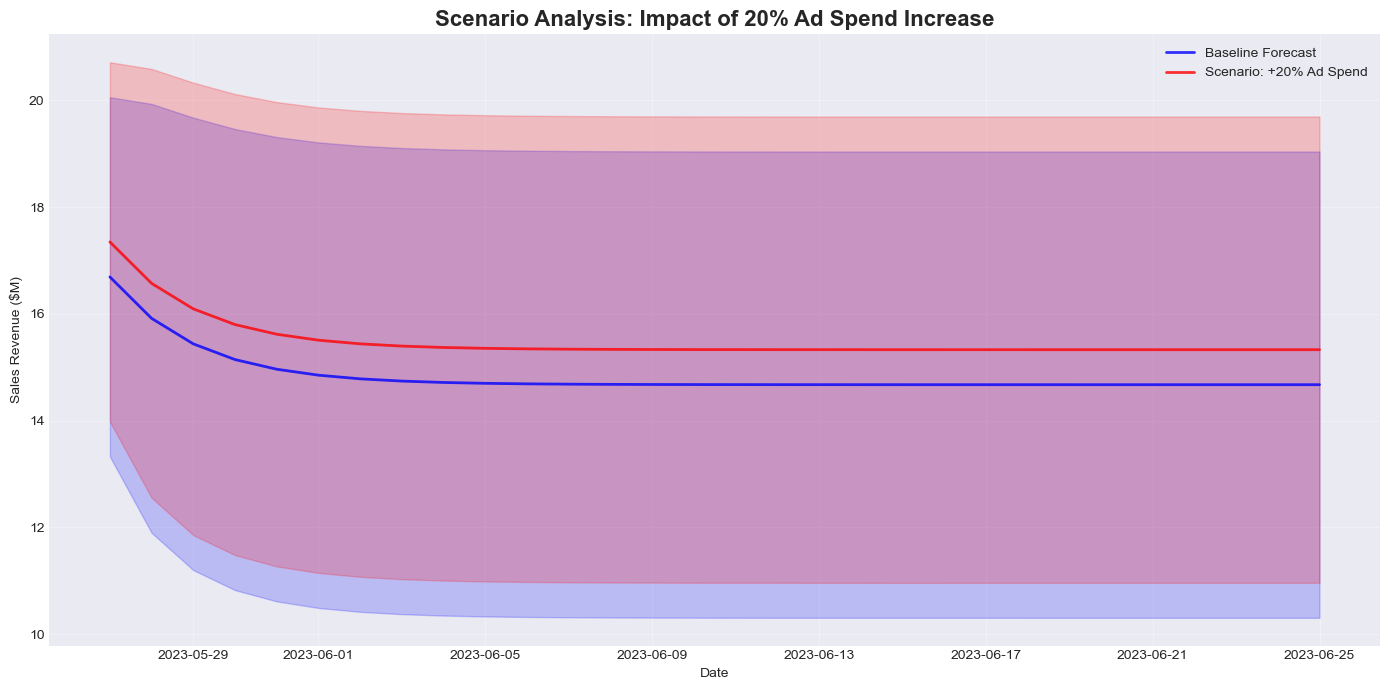

In [9]:
# Scenario: Increase ad spend by 20% for next 30 days
print("Scenario Analysis: 20% Increase in Ad Spend")
print("=" * 60)

# Baseline: Use last observed values
baseline_ad = train['ad_spend'].iloc[-1]
baseline_price = train['price_index'].iloc[-1]

# Scenario: 20% increase in ad spend
scenario_ad = baseline_ad * 1.20
scenario_price = baseline_price  # Price unchanged

# Create scenario exogenous variables
scenario_days = 30
scenario_dates = pd.date_range(start=test.index[0], periods=scenario_days, freq='D')

exog_baseline = pd.DataFrame({
    'ad_spend': [baseline_ad] * scenario_days,
    'price_index': [baseline_price] * scenario_days
}, index=scenario_dates)

exog_scenario = pd.DataFrame({
    'ad_spend': [scenario_ad] * scenario_days,
    'price_index': [baseline_price] * scenario_days
}, index=scenario_dates)

# Generate forecasts
forecast_baseline = arimax_fitted.get_forecast(steps=scenario_days, exog=exog_baseline)
forecast_scenario = arimax_fitted.get_forecast(steps=scenario_days, exog=exog_scenario)

baseline_pred = forecast_baseline.predicted_mean
scenario_pred = forecast_scenario.predicted_mean

# Calculate impact
impact = scenario_pred - baseline_pred
avg_impact = impact.mean()
total_impact = impact.sum()

print(f"\nBaseline Ad Spend: ${baseline_ad:.2f}M")
print(f"Scenario Ad Spend: ${scenario_ad:.2f}M (20% increase)")
print(f"\nAverage Daily Sales Impact: ${avg_impact:.2f}M")
print(f"Total 30-Day Sales Impact: ${total_impact:.2f}M")
print(f"\nROI: ${total_impact:.2f}M additional sales from ${(scenario_ad - baseline_ad) * scenario_days:.2f}M additional ad spend")

# Plot scenario comparison
fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(scenario_dates, baseline_pred, 'b-', linewidth=2, alpha=0.8, label='Baseline Forecast')
ax.plot(scenario_dates, scenario_pred, 'r-', linewidth=2, alpha=0.8, label='Scenario: +20% Ad Spend')
ax.fill_between(scenario_dates, 
                forecast_baseline.conf_int().iloc[:, 0], 
                forecast_baseline.conf_int().iloc[:, 1], 
                alpha=0.2, color='blue')
ax.fill_between(scenario_dates, 
                forecast_scenario.conf_int().iloc[:, 0], 
                forecast_scenario.conf_int().iloc[:, 1], 
                alpha=0.2, color='red')

ax.set_title('Scenario Analysis: Impact of 20% Ad Spend Increase', fontsize=16, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Sales Revenue ($M)')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Part 7: Distributed Lag Models

Distributed lag models allow us to estimate how effects of x on y are distributed across multiple time periods.

Fitting Distributed Lag Model...

Distributed Lag Model Results (OLS with standard errors):
                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     12.21
Date:                Sun, 08 Feb 2026   Prob (F-statistic):           1.89e-11
Time:                        09:35:34   Log-Likelihood:                -1930.0
No. Observations:                 873   AIC:                             3872.
Df Residuals:                     867   BIC:                             3901.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

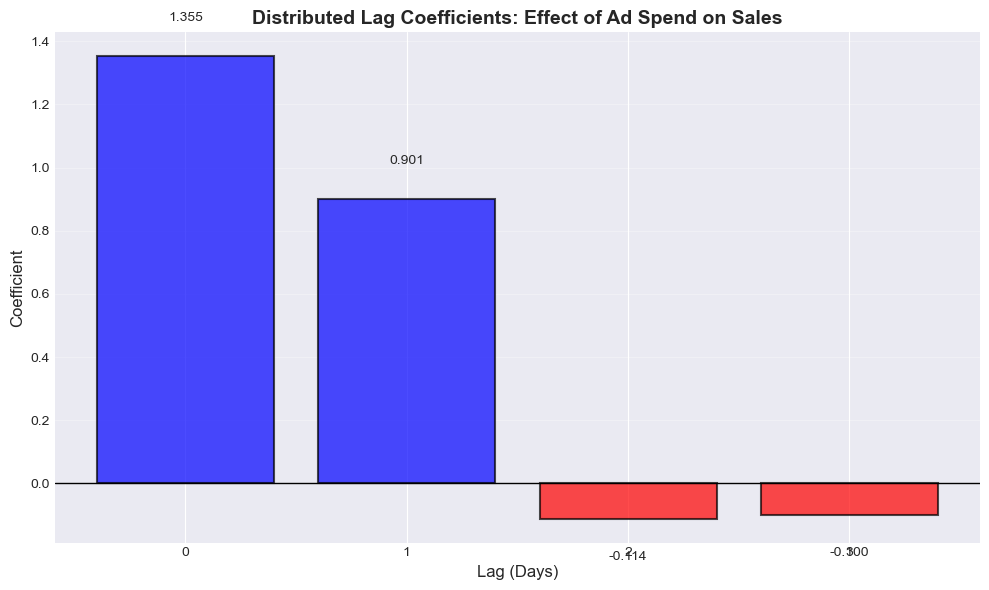

In [10]:
# Fit distributed lag model
print("Fitting Distributed Lag Model...")
print("=" * 60)

# Create lagged variables for ad_spend (contemporary + 3 lags)
train_dl = train.copy()
train_dl['ad_spend_lag0'] = train_dl['ad_spend']
train_dl['ad_spend_lag1'] = train_dl['ad_spend'].shift(1)
train_dl['ad_spend_lag2'] = train_dl['ad_spend'].shift(2)
train_dl['ad_spend_lag3'] = train_dl['ad_spend'].shift(3)

# Drop rows with NaN (due to lags)
train_dl = train_dl.dropna()

# Prepare data for regression
X_dl = sm.add_constant(train_dl[['ad_spend_lag0', 'ad_spend_lag1', 'ad_spend_lag2', 'ad_spend_lag3', 'price_index']])
y_dl = train_dl['sales']

# Fit OLS (we'll add HAC standard errors next)
dl_model = OLS(y_dl, X_dl).fit()

print("\nDistributed Lag Model Results (OLS with standard errors):")
print(dl_model.summary())

# Extract lag coefficients
lag_coefs = dl_model.params[['ad_spend_lag0', 'ad_spend_lag1', 'ad_spend_lag2', 'ad_spend_lag3']]

print("\n" + "=" * 60)
print("Lag Coefficients:")
print("=" * 60)
for i, (lag, coef) in enumerate(lag_coefs.items()):
    lag_num = int(lag.split('_')[-1][-1])
    print(f"  Lag {lag_num}: {coef:.4f} (contemporary effect if lag 0)")

# Calculate long-run multiplier (sum of all lag coefficients)
long_run_multiplier = lag_coefs.sum()
print(f"\nLong-Run Multiplier (sum of lag coefficients): {long_run_multiplier:.4f}")
print(f"  Interpretation: Total effect of a permanent $1M increase in ad spend")

# Plot lag distribution
fig, ax = plt.subplots(figsize=(10, 6))

lags = [0, 1, 2, 3]
coefs = lag_coefs.values
colors = ['blue' if c > 0 else 'red' for c in coefs]

ax.bar(lags, coefs, alpha=0.7, color=colors, edgecolor='black', linewidth=1.5)
ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax.set_xlabel('Lag (Days)', fontsize=12)
ax.set_ylabel('Coefficient', fontsize=12)
ax.set_title('Distributed Lag Coefficients: Effect of Ad Spend on Sales', fontsize=14, fontweight='bold')
ax.set_xticks(lags)
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for lag, coef in zip(lags, coefs):
    ax.text(lag, coef + (0.1 if coef > 0 else -0.1), f'{coef:.3f}', 
            ha='center', va='bottom' if coef > 0 else 'top', fontsize=10)

plt.tight_layout()
plt.show()

## Part 8: HAC Standard Errors

HAC (Heteroskedasticity and Autocorrelation Consistent) standard errors correct inference when errors are serially correlated, without changing coefficient estimates.

Computing HAC Standard Errors...

Sample size: 873
HAC lag length (L): 6 (rule of thumb: 4*(T/100)^(2/9))

Standard Error Comparison:

Variable             OLS SE       HAC SE       Ratio (HAC/OLS)
------------------------------------------------------------
const                0.8778       1.3051       1.49           
ad_spend_lag0        0.3378       0.2996       0.89           
ad_spend_lag1        0.3367       0.3052       0.91           
ad_spend_lag2        0.3366       0.2685       0.80           
ad_spend_lag3        0.3388       0.3017       0.89           
price_index          0.4972       0.7151       1.44           

Key Insight: HAC standard errors account for serial correlation
They are typically larger than OLS SEs, leading to wider confidence intervals
and more conservative hypothesis tests.

Significance Comparison (|t| > 1.96 for 5% level):
               Coefficient  OLS t-stat  HAC t-stat  OLS Significant  HAC Significant
const             9.972627   11.361318    7

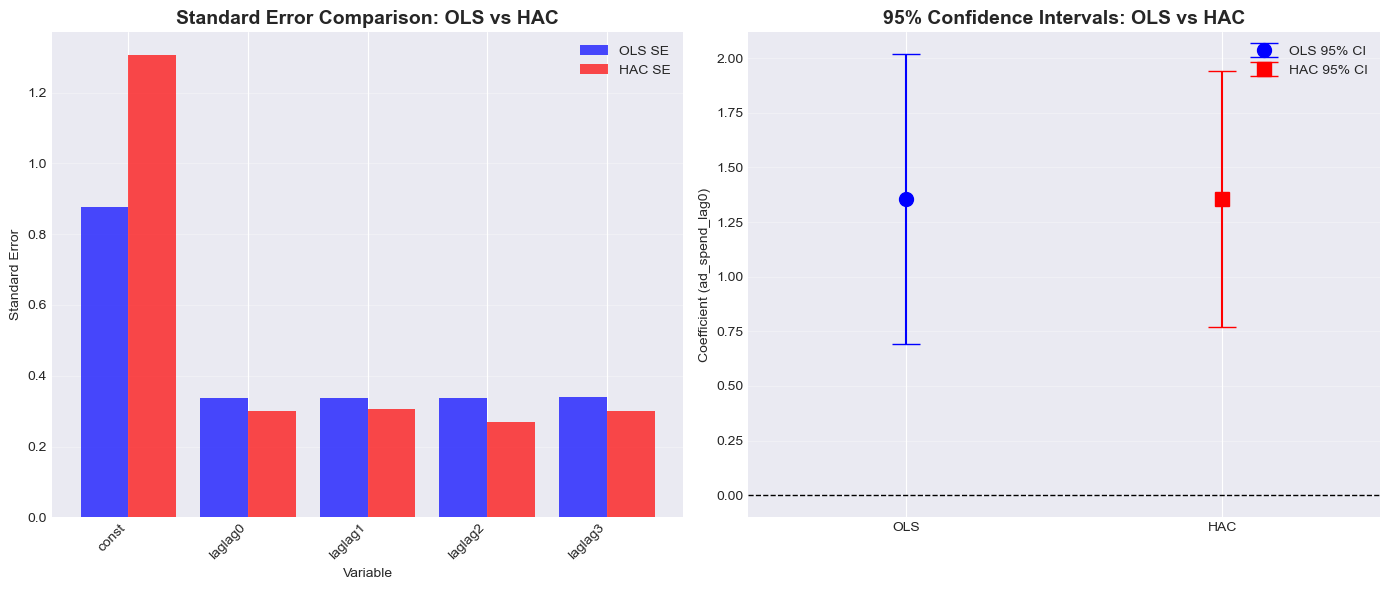

In [11]:
# Compute HAC standard errors
print("Computing HAC Standard Errors...")
print("=" * 60)

# Get residuals from distributed lag model
dl_residuals = dl_model.resid

# Compute HAC covariance matrix (Newey-West)
# Choose lag length: L ≈ 4(T/100)^(2/9)
T = len(dl_residuals)
L = int(4 * (T / 100) ** (2/9))
print(f"\nSample size: {T}")
print(f"HAC lag length (L): {L} (rule of thumb: 4*(T/100)^(2/9))")

# Compute HAC covariance matrix
cov_hac_matrix = cov_hac(dl_model, nlags=L)

# Get HAC standard errors
se_hac = np.sqrt(np.diag(cov_hac_matrix))

# Compare with OLS standard errors
se_ols = dl_model.bse

print("\n" + "=" * 60)
print("Standard Error Comparison:")
print("=" * 60)
print(f"\n{'Variable':<20} {'OLS SE':<12} {'HAC SE':<12} {'Ratio (HAC/OLS)':<15}")
print("-" * 60)
for var, se_o, se_h in zip(dl_model.params.index, se_ols, se_hac):
    ratio = se_h / se_o if se_o > 0 else np.nan
    print(f"{var:<20} {se_o:<12.4f} {se_h:<12.4f} {ratio:<15.2f}")

print("\n" + "=" * 60)
print("Key Insight: HAC standard errors account for serial correlation")
print("They are typically larger than OLS SEs, leading to wider confidence intervals")
print("and more conservative hypothesis tests.")

# Create comparison table
comparison_df = pd.DataFrame({
    'Coefficient': dl_model.params.values,
    'OLS SE': se_ols.values,
    'HAC SE': se_hac,
    'OLS t-stat': dl_model.params.values / se_ols.values,
    'HAC t-stat': dl_model.params.values / se_hac
}, index=dl_model.params.index)

comparison_df['OLS Significant'] = np.abs(comparison_df['OLS t-stat']) > 1.96
comparison_df['HAC Significant'] = np.abs(comparison_df['HAC t-stat']) > 1.96

print("\n" + "=" * 60)
print("Significance Comparison (|t| > 1.96 for 5% level):")
print("=" * 60)
print(comparison_df[['Coefficient', 'OLS t-stat', 'HAC t-stat', 'OLS Significant', 'HAC Significant']].to_string())

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Standard errors comparison
vars_to_plot = [v for v in dl_model.params.index if 'ad_spend' in v or v == 'const']
x_pos = np.arange(len(vars_to_plot))

axes[0].bar(x_pos - 0.2, se_ols[vars_to_plot], 0.4, label='OLS SE', alpha=0.7, color='blue')
axes[0].bar(x_pos + 0.2, se_hac[[dl_model.params.index.get_loc(v) for v in vars_to_plot]], 0.4, label='HAC SE', alpha=0.7, color='red')
axes[0].set_xlabel('Variable')
axes[0].set_ylabel('Standard Error')
axes[0].set_title('Standard Error Comparison: OLS vs HAC', fontsize=14, fontweight='bold')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels([v.replace('ad_spend_', 'lag') for v in vars_to_plot], rotation=45, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Confidence intervals comparison (for ad_spend_lag0)
coef_lag0 = dl_model.params['ad_spend_lag0']
ci_ols_lower = coef_lag0 - 1.96 * se_ols['ad_spend_lag0']
ci_ols_upper = coef_lag0 + 1.96 * se_ols['ad_spend_lag0']
lag0_idx = dl_model.params.index.get_loc('ad_spend_lag0')
ci_hac_lower = coef_lag0 - 1.96 * se_hac[lag0_idx]
ci_hac_upper = coef_lag0 + 1.96 * se_hac[lag0_idx]

axes[1].errorbar([0], [coef_lag0], yerr=[[coef_lag0 - ci_ols_lower], [ci_ols_upper - coef_lag0]], 
                fmt='o', capsize=10, label='OLS 95% CI', color='blue', markersize=10)
axes[1].errorbar([1], [coef_lag0], yerr=[[coef_lag0 - ci_hac_lower], [ci_hac_upper - coef_lag0]], 
                fmt='s', capsize=10, label='HAC 95% CI', color='red', markersize=10)
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[1].set_xlim(-0.5, 1.5)
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['OLS', 'HAC'])
axes[1].set_ylabel('Coefficient (ad_spend_lag0)')
axes[1].set_title('95% Confidence Intervals: OLS vs HAC', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## Part 9: Long-Run Effects

The long-run multiplier captures the total cumulative effect of a permanent change in x on y.

Long-Run Multiplier Analysis

Long-Run Multiplier: 2.0419
  Standard Error (HAC): 0.5257
  95% Confidence Interval: [1.0116, 3.0722]

Interpretation:
  A permanent $1M increase in ad spend leads to a 2.04M increase in sales
  in the long run (after all lagged effects have fully materialized).

True Long-Run Multiplier (from DGP): 3.1000
  Estimated: 2.0419
  Error: 1.0581


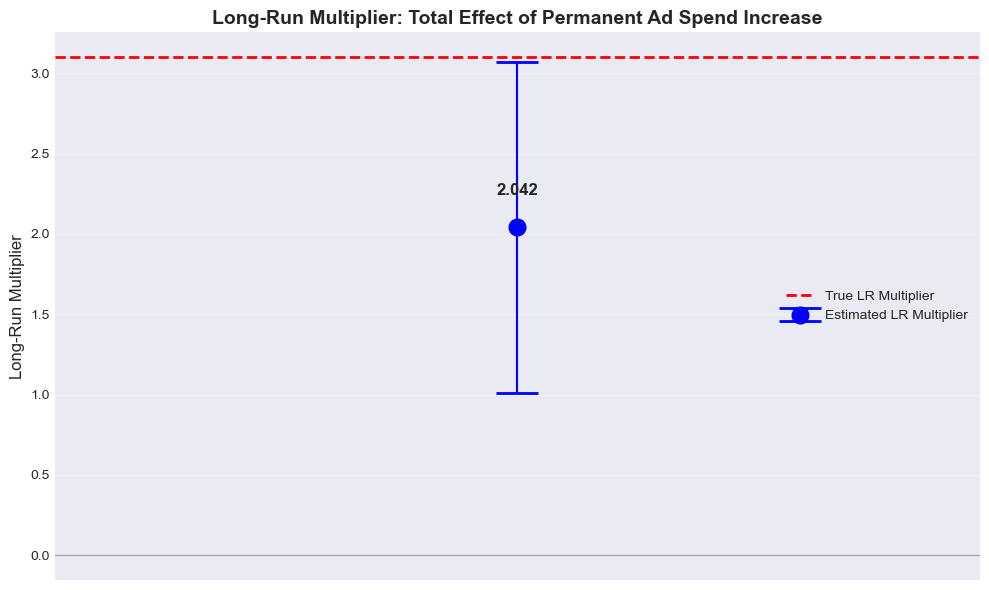


Key Takeaway: Long-run effects require joint inference across all lags.
HAC standard errors ensure valid confidence intervals for cumulative effects.


In [12]:
# Calculate long-run multiplier with HAC inference
print("Long-Run Multiplier Analysis")
print("=" * 60)

# Long-run multiplier = sum of lag coefficients
lr_multiplier = lag_coefs.sum()

# Standard error of long-run multiplier
# This requires the covariance matrix of the lag coefficients
lag_indices = [dl_model.params.index.get_loc(lag) for lag in lag_coefs.index]
cov_lags = cov_hac_matrix[lag_indices, :][:, lag_indices]

# Variance of sum = sum of all elements in covariance matrix
var_lr = cov_lags.sum()
se_lr = np.sqrt(var_lr)

# 95% confidence interval
ci_lr_lower = lr_multiplier - 1.96 * se_lr
ci_lr_upper = lr_multiplier + 1.96 * se_lr

print(f"\nLong-Run Multiplier: {lr_multiplier:.4f}")
print(f"  Standard Error (HAC): {se_lr:.4f}")
print(f"  95% Confidence Interval: [{ci_lr_lower:.4f}, {ci_lr_upper:.4f}]")
print(f"\nInterpretation:")
print(f"  A permanent $1M increase in ad spend leads to a {lr_multiplier:.2f}M increase in sales")
print(f"  in the long run (after all lagged effects have fully materialized).")

# Compare with true value (from DGP)
true_lr_multiplier = 1.5 + 0.8 + 0.5 + 0.3  # Sum of true lag coefficients
print(f"\nTrue Long-Run Multiplier (from DGP): {true_lr_multiplier:.4f}")
print(f"  Estimated: {lr_multiplier:.4f}")
print(f"  Error: {abs(lr_multiplier - true_lr_multiplier):.4f}")

# Plot long-run multiplier with confidence interval
fig, ax = plt.subplots(figsize=(10, 6))

ax.errorbar([0], [lr_multiplier], yerr=[[lr_multiplier - ci_lr_lower], [ci_lr_upper - lr_multiplier]], 
            fmt='o', capsize=15, capthick=2, markersize=12, color='blue', label='Estimated LR Multiplier')
ax.axhline(y=true_lr_multiplier, color='red', linestyle='--', linewidth=2, label='True LR Multiplier')
ax.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.3)
ax.set_xlim(-0.5, 0.5)
ax.set_xticks([])
ax.set_ylabel('Long-Run Multiplier', fontsize=12)
ax.set_title('Long-Run Multiplier: Total Effect of Permanent Ad Spend Increase', fontsize=14, fontweight='bold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3, axis='y')

# Add text annotation
ax.text(0, lr_multiplier + 0.2, f'{lr_multiplier:.3f}', ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("Key Takeaway: Long-run effects require joint inference across all lags.")
print("HAC standard errors ensure valid confidence intervals for cumulative effects.")

## Part 10: Summary and Key Takeaways

### What We Learned:

1. **OLS fails in time series** when errors are serially correlated
   - Standard errors are wrong
   - Forecasts are inefficient

2. **ARIMAX models** combine regression with ARIMA errors
   - Captures both regression effects and serial correlation
   - Enables conditional forecasting

3. **Conditional vs Unconditional Forecasts**
   - Conditional: Given future x (scenario analysis)
   - Unconditional: Must forecast x first

4. **Distributed Lag Models**
   - Estimate effects distributed across multiple periods
   - Essential for understanding dynamic causal effects

5. **HAC Standard Errors**
   - Correct inference when errors are serially correlated
   - Do not change coefficient estimates
   - Essential for valid hypothesis tests

6. **Long-Run Multipliers**
   - Sum of all lag coefficients
   - Total cumulative effect of permanent changes
   - Require joint inference (HAC)

### When to Use What:

- **Forecasting**: Use ARIMAX
- **Causal Inference**: Use distributed lags + HAC
- **Scenario Analysis**: Use conditional forecasts with ARIMAX
- **Policy Analysis**: Focus on long-run multipliers